In [ ]:
import json
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm

nlp = en_core_web_sm.load()


In [ ]:
#Importing libraries required for the case study and to plot charts
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import os
from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px
%matplotlib inline


In [ ]:
import re

# hide warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

# **Data Loading**


data in json so covert in dataframe

In [ ]:
# opening json file and returning JSON object as a dictionary

data = json.load(open('/content/drive/MyDrive/ticket_complaints.json'))

In [ ]:
df = pd.json_normalize(data)

In [ ]:
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [ ]:
# assigen new column names

df = df[['_source.complaint_what_happened', '_source.product', '_source.sub_product']]
df.head()

,_source.complaint_what_happened,_source.product,_source.sub_product
0,,Debt collection,Credit card debt
1,Good morning my name is XXXX XXXX and I apprec...,Debt collection,Credit card debt
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card,General-purpose credit card or charge card
3,,Mortgage,Conventional home mortgage
4,,Credit card or prepaid card,General-purpose credit card or charge card


In [ ]:
# lets rename the column names to be more read friendly
# we have retained product and sub_product only for verification purpose ,
# these columns will not be used in the Topic modelling

df = df.rename( columns = {'_source.complaint_what_happened': 'complaint_text', '_source.product' : 'category', '_source.sub_product' : 'sub_category' })
df

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# lets merge the category and sub-category this will help us in deciding the topics after NMF modelling

df['category'] = df['category'] + '+' + df['sub_category']
df = df.drop(['sub_category'], axis=1)
df.head()

,complaint_text,category
0,,Debt collection+Credit card debt
1,Good morning my name is XXXX XXXX and I apprec...,Debt collection+Credit card debt
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card+General-purpose cr...
3,,Mortgage+Conventional home mortgage
4,,Credit card or prepaid card+General-purpose cr...


In [ ]:
df.complaint_text.isnull().sum()

np.int64(0)

In [ ]:
len(df.complaint_text)

78313

In [ ]:
# check empty string in complaimt

df['complaint_text']==''

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
len(df[df['complaint_text']==''])

57241

In [ ]:
# Replace empty string with nan

df[df['complaint_text']==''] = np.nan

df.complaint_text.isnull().sum()

np.int64(57241)

In [ ]:
df.dtypes

,0
complaint_text,object
category,object


In [ ]:
#Remove all rows where complaints column is nan
# Lets drop all the rows where complaint_text is null

df = df[~df['complaint_text'].isnull()]

In [ ]:
df.complaint_text.isnull().sum()

np.int64(0)

# **Text Processing**

### **Prepare the text for topic modeling**

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Use POS tags to get relevant words from the texts.

In [ ]:
# write function here to clean text and remove unneccsary element
# preparing text for topic modelling

def clean_text(text):
   text = text.lower()           # Make  text lowercase
   text = re.sub('\[.*\]', '', text).strip()            # Remove text in square brackets
   text = text.translate(str.maketrans('', '', string.punctuation))           #  Remove punctuation
   text = re.sub('\S*\d\S*\S*', '', text).strip()               # # Remove words containing numbers
   return text.strip()


In [ ]:
df.complaint_text = df.complaint_text.apply(lambda x: clean_text(x))
df.complaint_text.head()

,complaint_text
1,good morning my name is xxxx xxxx and i apprec...
2,i upgraded my xxxx xxxx card in and was told ...
10,chase card was reported on however fraudulent...
11,on while trying to book a xxxx xxxx ticket ...
14,my grand son give me check for i deposit it i...


# Data Lemmatize

In [ ]:
#Write your function to Lemmatize the texts
# lemmatization
#Function to Lemmatize the texts

stopwords = nlp.Defaults.stop_words

def lemmatizer(text):
    doc = nlp(text)
    sent = [token.lemma_ for token in doc if not token.text in set(stopwords)]
    return ' '.join(sent)

In [ ]:
# Lemmatize the complaints

df['lemma'] = df.complaint_text.apply(lambda x: lemmatizer(x))
df.head()

,complaint_text,category,lemma
1,good morning my name is xxxx xxxx and i apprec...,Debt collection+Credit card debt,good morning xxxx xxxx appreciate help stop ch...
2,i upgraded my xxxx xxxx card in and was told ...,Credit card or prepaid card+General-purpose cr...,upgrade xxxx xxxx card tell agent upgrade an...
10,chase card was reported on however fraudulent...,"Credit reporting, credit repair services, or o...",chase card report fraudulent application sub...
11,on while trying to book a xxxx xxxx ticket ...,"Credit reporting, credit repair services, or o...",try book xxxx xxxx ticket come offer a...
14,my grand son give me check for i deposit it i...,Checking or savings account+Checking account,grand son check deposit chase account fund c...


In [ ]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints

df_clean = df[['complaint_text', 'lemma', 'category']]

In [ ]:
df_clean.head()

,complaint_text,lemma,category
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,Debt collection+Credit card debt
2,i upgraded my xxxx xxxx card in and was told ...,upgrade xxxx xxxx card tell agent upgrade an...,Credit card or prepaid card+General-purpose cr...
10,chase card was reported on however fraudulent...,chase card report fraudulent application sub...,"Credit reporting, credit repair services, or o..."
11,on while trying to book a xxxx xxxx ticket ...,try book xxxx xxxx ticket come offer a...,"Credit reporting, credit repair services, or o..."
14,my grand son give me check for i deposit it i...,grand son check deposit chase account fund c...,Checking or savings account+Checking account


# **Data Pos tag Extraction**


In [ ]:
#Write your function to extract the POS tags NN

def extract_pos_tags(text):
   doc = nlp(text)
   sent = [ token.text for token in doc if token.tag_ == 'NN']         #  what NN
   return ' '.join(sent)

In [ ]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.

df_clean['complaint_POS_removed'] = df_clean.lemma.apply(lambda x: extract_pos_tags(x))
df_clean.head()

,complaint_text,lemma,category,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,Debt collection+Credit card debt,morning help chase debt verification statement...
2,i upgraded my xxxx xxxx card in and was told ...,upgrade xxxx xxxx card tell agent upgrade an...,Credit card or prepaid card+General-purpose cr...,card agent anniversary date change agent infor...
10,chase card was reported on however fraudulent...,chase card report fraudulent application sub...,"Credit reporting, credit repair services, or o...",card report application identity consent servi...
11,on while trying to book a xxxx xxxx ticket ...,try book xxxx xxxx ticket come offer a...,"Credit reporting, credit repair services, or o...",book ticket offer ticket reward card informati...
14,my grand son give me check for i deposit it i...,grand son check deposit chase account fund c...,Checking or savings account+Checking account,son deposit chase account fund account pay mon...


# EDA - Exportary Data analysis

### **Exploratory data analysis to get familiar with the data.**

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘


(array([9.484e+03, 6.329e+03, 2.656e+03, 1.233e+03, 6.990e+02, 2.630e+02,
        1.260e+02, 7.400e+01, 5.900e+01, 3.400e+01, 3.200e+01, 1.200e+01,
        1.200e+01, 1.500e+01, 4.000e+00, 9.000e+00, 2.000e+00, 3.000e+00,
        3.000e+00, 4.000e+00, 7.000e+00, 0.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 3.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00]),
 array([    0.  ,   248.84,   497.68,   746.52,   995.36,  1244.2 ,
         1493.04,  1741.88,  1990.72,  2239.56,  2488.4 ,  2737.24,
         2986.08,  3234.92,  3483.76,  3732.6 ,  3981.44,  4230.28,
         4479.12,  4727.96,  4976.8 ,  5225.64,  5474.48,  5723.32,
         5972.16,  6221.  ,  6469.84,  6718.68,  6967.52,  7216.36,
         7465.2 ,  7714.04,  7962.88

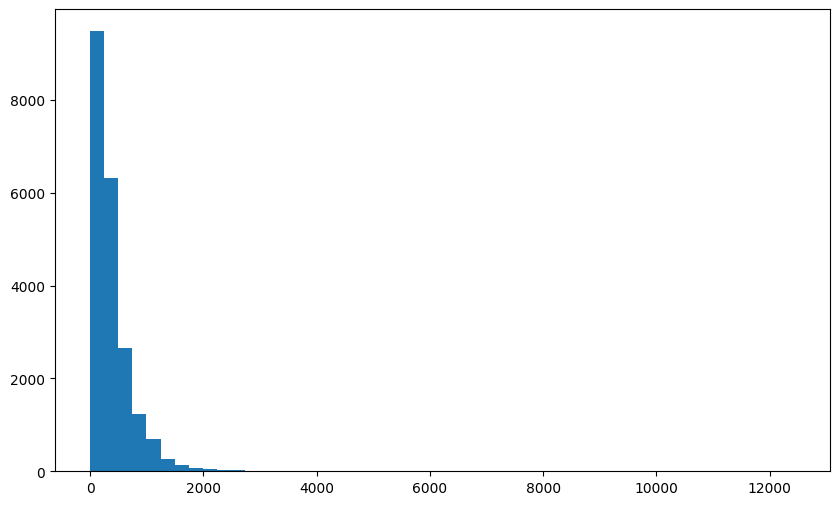

In [ ]:
# Write your code here to visualise the data according to the 'Complaint' character length

plt.figure(figsize=(10,6))
doc_lens = [len(d) for d in df_clean.complaint_POS_removed]
plt.hist(doc_lens, bins = 50)

In [ ]:
! pip install wordcloud

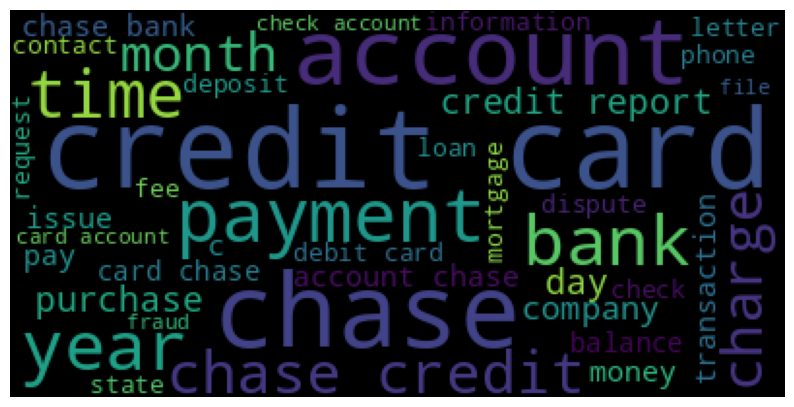

In [ ]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text

from wordcloud import WordCloud

wordcloud = WordCloud(stopwords = stopwords, max_words=40).generate(str(df_clean.complaint_POS_removed))

print(wordcloud)
plt.figure(figsize=(10,6))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [ ]:
#Removing -PRON- from the text corpus

df_clean['complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON', '')   # what is pron
df_clean = df_clean.drop(['complaint_POS_removed'], axis=1)

In [ ]:
df_clean.head()


,complaint_text,lemma,category,complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,Debt collection+Credit card debt,morning help chase debt verification statement...
2,i upgraded my xxxx xxxx card in and was told ...,upgrade xxxx xxxx card tell agent upgrade an...,Credit card or prepaid card+General-purpose cr...,card agent anniversary date change agent infor...
10,chase card was reported on however fraudulent...,chase card report fraudulent application sub...,"Credit reporting, credit repair services, or o...",card report application identity consent servi...
11,on while trying to book a xxxx xxxx ticket ...,try book xxxx xxxx ticket come offer a...,"Credit reporting, credit repair services, or o...",book ticket offer ticket reward card informati...
14,my grand son give me check for i deposit it i...,grand son check deposit chase account fund c...,Checking or savings account+Checking account,son deposit chase account fund account pay mon...


# **Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.**

In [ ]:
# Write your code here to find the top 30 unigram,bigram,trigram frequency
# among the complaints in the cleaned datafram(df_clean).

In [ ]:
def get_top_n_bigram(text, ngram=1, top=None):
    vec = CountVectorizer(ngram_range= (ngram, ngram), stop_words='english').fit(text)
    bag_of_words = vec.transform(text)

    sum_words = bag_of_words.sum(axis=0)
    words_freq = [ (word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]

    words_freq = sorted(words_freq, key = lambda x: x[1], reverse= True)

    return words_freq[:top]

In [ ]:
top_30_unigrams = get_top_n_bigram(df_clean.complaint_clean, ngram=1, top=30)
top_30_bigrams = get_top_n_bigram(df_clean.complaint_clean, ngram=2, top=30)
top_30_trigrams = get_top_n_bigram(df_clean.complaint_clean, ngram=3, top=30)

In [ ]:
#Print the top 10 words in the unigram frequency
print('Top 10 unigrams:\n')
top_30_unigrams[:10]

Top 10 unigrams:



[('chase', np.int64(59028)),
 ('account', np.int64(42200)),
 ('credit', np.int64(33595)),
 ('card', np.int64(29975)),
 ('payment', np.int64(20974)),
 ('charge', np.int64(16247)),
 ('time', np.int64(15484)),
 ('bank', np.int64(13537)),
 ('day', np.int64(12224)),
 ('money', np.int64(11609))]

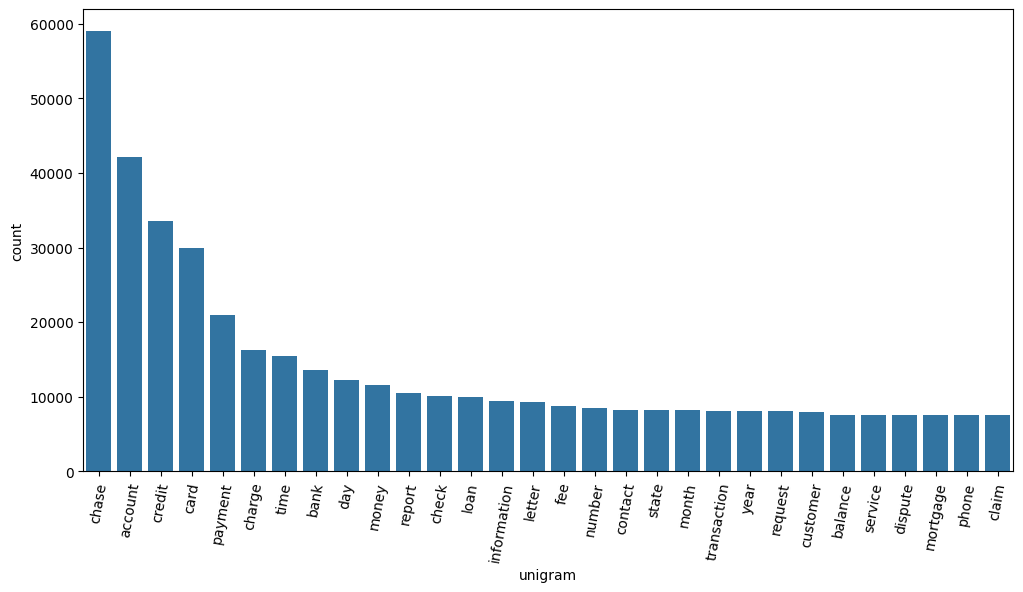

In [ ]:
#Plot graph for the top 30 words in the unigram frequency
df1 = pd.DataFrame(top_30_unigrams, columns = ['unigram' , 'count'])
plt.figure(figsize=(12,6))
fig = sns.barplot(x=df1['unigram'], y=df1['count'])
plt.xticks(rotation = 80)
plt.show()

In [ ]:
#Print the top 10 words in the bigram frequency
print('Top 10 bigrams:\n')
top_30_bigrams[:10]

Top 10 bigrams:



[('credit card', np.int64(12734)),
 ('credit report', np.int64(3869)),
 ('chase credit', np.int64(3153)),
 ('account chase', np.int64(3002)),
 ('customer service', np.int64(2968)),
 ('chase bank', np.int64(2860)),
 ('chase account', np.int64(2410)),
 ('contact chase', np.int64(2050)),
 ('account account', np.int64(1960)),
 ('debit card', np.int64(1933))]

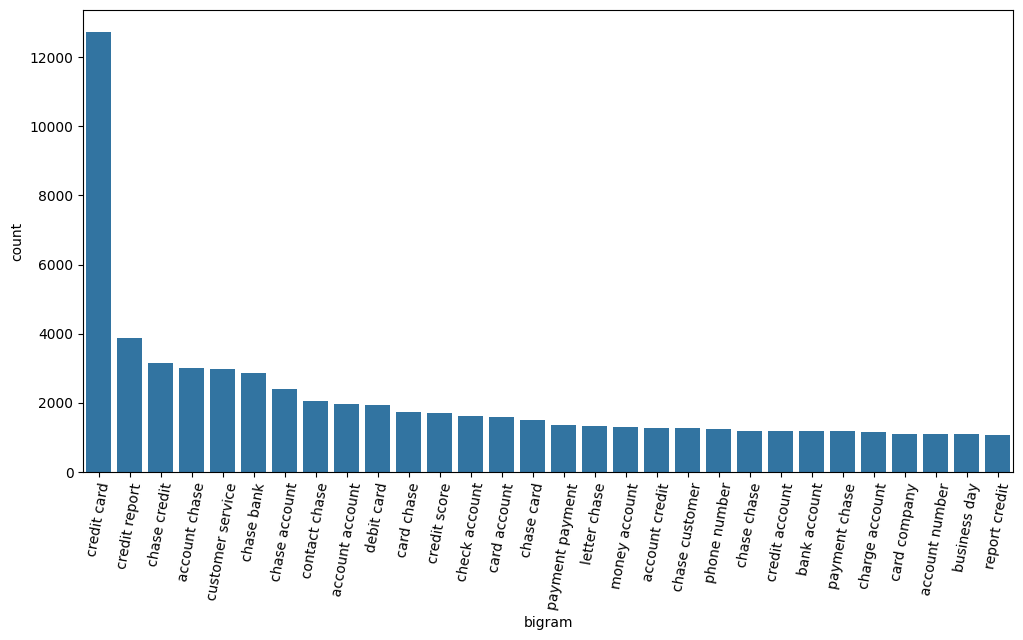

In [ ]:
#Plot graph for the top 30 words in the bigram frequency
df2 = pd.DataFrame(top_30_bigrams, columns = ['bigram' , 'count'])
plt.figure(figsize=(12,6))
fig = sns.barplot(x=df2['bigram'], y=df2['count'])
plt.xticks(rotation = 80)
plt.show()

In [ ]:
#Print the top 10 words in the trigram frequency
print('Top 10 trigrams:\n')
top_30_trigrams[:10]

Top 10 trigrams:



[('chase credit card', np.int64(2226)),
 ('credit card account', np.int64(1054)),
 ('credit card company', np.int64(983)),
 ('credit card chase', np.int64(874)),
 ('chase customer service', np.int64(620)),
 ('inquiry credit report', np.int64(494)),
 ('charge credit card', np.int64(490)),
 ('credit card credit', np.int64(454)),
 ('credit reporting agency', np.int64(377)),
 ('account credit card', np.int64(353))]

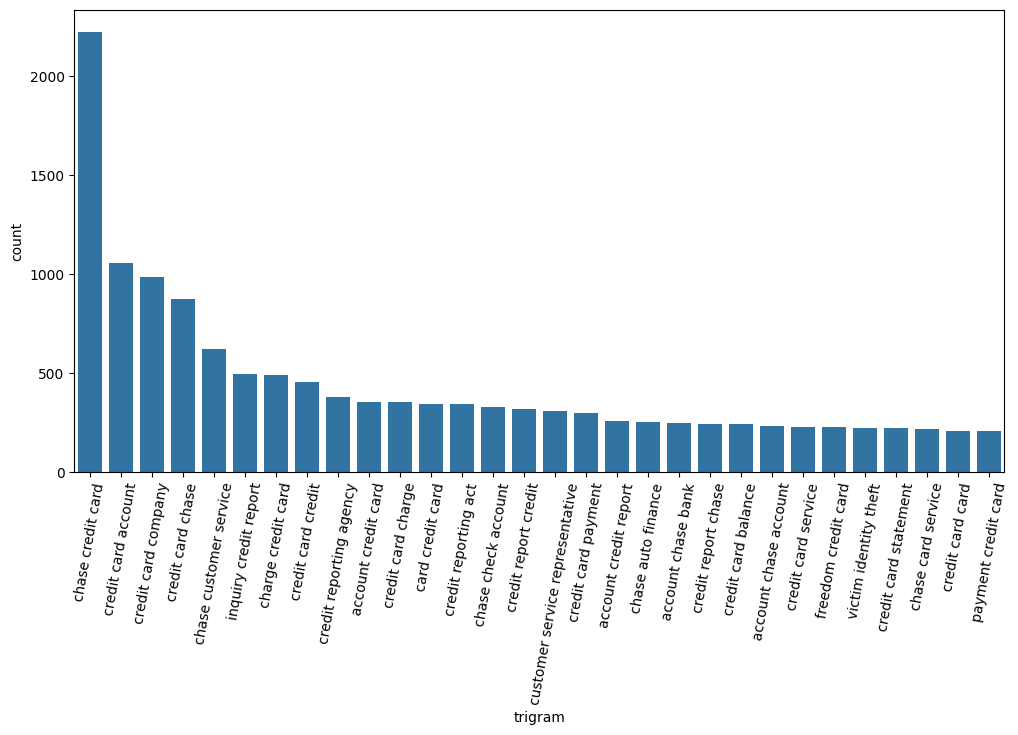

In [ ]:
#Plot graph for the top 30 words in the trigram frequency
df3 = pd.DataFrame(top_30_trigrams, columns = ['trigram' , 'count'])
plt.figure(figsize=(12,6))
fig = sns.barplot(x=df3['trigram'], y=df3['count'])
plt.xticks(rotation = 80)
plt.show()

#### **The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis**

In [ ]:
df_clean['complaint_clean'] = df_clean['complaint_clean'].str.replace('xxxx', '')

In [ ]:
#All masked texts has been removed
df_clean.head()

,complaint_text,lemma,category,complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,Debt collection+Credit card debt,morning help chase debt verification statement...
2,i upgraded my xxxx xxxx card in and was told ...,upgrade xxxx xxxx card tell agent upgrade an...,Credit card or prepaid card+General-purpose cr...,card agent anniversary date change agent infor...
10,chase card was reported on however fraudulent...,chase card report fraudulent application sub...,"Credit reporting, credit repair services, or o...",card report application identity consent servi...
11,on while trying to book a xxxx xxxx ticket ...,try book xxxx xxxx ticket come offer a...,"Credit reporting, credit repair services, or o...",book ticket offer ticket reward card informati...
14,my grand son give me check for i deposit it i...,grand son check deposit chase account fund c...,Checking or savings account+Checking account,son deposit chase account fund account pay mon...


# **Feature Extraction**

### **Convert the raw texts to a matrix of TF-IDF features**

- **max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

- **min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [ ]:
# inintalize Tfidfvectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


tfidf = TfidfVectorizer(min_df = 2, max_df=0.95, stop_words ='english')

#### **Create a document term matrix using fit_transform**

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [ ]:
# write code to create document Term matrix by transforming complaint column present in df_clean

dtm = tfidf.fit_transform(df_clean.complaint_clean)

In [ ]:
tfidf.get_feature_names_out()[:10]


array(['aarp', 'abandonment', 'abate', 'abatement', 'abbreviation',
       'abhorrent', 'abide', 'ability', 'abovementione', 'abovereference'],
      dtype=object)

In [ ]:
len(tfidf.get_feature_names_out())

6523

# **Topic Modelling**

## **Topic Modelling using NMF**

- ### **Non-Negative Matrix Factorization (NMF)**
It is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

- In this task we are performing the following:

 * Find the best number of clusters
 * Apply the best number to create word clusters
 * Inspect & validate the correction of each cluster wrt the complaints
 * Correct the labels if needed
 * Map the clusters to topics/cluster names

## **Non-Negative Matrix Factorization (NMF)**


In [ ]:
from sklearn.decomposition import NMF

In [ ]:
# Load your nmf_model with n component

num_topics = 5

nmf_model = NMF(n_components = num_topics, random_state = 40)

w1 = nmf_model.fit_transform(dtm)
h1 = nmf_model.components_

In [ ]:
#nmf_model.fit(dtm)
#len(tfidf.get_feature_names())

In [ ]:
# print Top 15 word for each of topics

num_words = 15

vocab = np.array(tfidf.get_feature_names_out())

top_words = lambda t : [ vocab[i] for i in np.argsort(t)[:-num_words-1:-1]]           # not understoo.

topic_words = ( [ top_words(t) for t in h1])

topics = [' '.join(t) for t in topic_words]

# NumPy function that tells you the index positions that would sort an array.
# returns the indices of elements in sorted order (not the values). Sorts indices

In [ ]:
vocab

array(['aarp', 'abandonment', 'abate', ..., 'zombie', 'zone', 'zoom'],
      dtype=object)

In [ ]:
len(vocab)

6523

In [ ]:
len(top_words)

TypeError: object of type 'function' has no len()

In [ ]:
top_words

<function __main__.<lambda>(t)>

In [ ]:
topic_words

[['account',
  'check',
  'money',
  'chase',
  'deposit',
  'bank',
  'fund',
  'day',
  'branch',
  'transfer',
  'number',
  'transaction',
  'business',
  'claim',
  'customer'],
 ['credit',
  'card',
  'report',
  'inquiry',
  'chase',
  'account',
  'score',
  'company',
  'information',
  'debt',
  'limit',
  'application',
  'letter',
  'year',
  'reporting'],
 ['payment',
  'balance',
  'month',
  'pay',
  'statement',
  'fee',
  'day',
  'time',
  'auto',
  'chase',
  'credit',
  'date',
  'mortgage',
  'error',
  'year'],
 ['charge',
  'card',
  'fee',
  'dispute',
  'chase',
  'transaction',
  'purchase',
  'merchant',
  'claim',
  'service',
  'balance',
  'fraud',
  'statement',
  'time',
  'email'],
 ['loan',
  'mortgage',
  'chase',
  'modification',
  'home',
  'property',
  'letter',
  'year',
  'document',
  'rate',
  'time',
  'request',
  'foreclosure',
  'sale',
  'information']]

In [ ]:
topics

['account check money chase deposit bank fund day branch transfer number transaction business claim customer',
 'credit card report inquiry chase account score company information debt limit application letter year reporting',
 'payment balance month pay statement fee day time auto chase credit date mortgage error year',
 'charge card fee dispute chase transaction purchase merchant claim service balance fraud statement time email',
 'loan mortgage chase modification home property letter year document rate time request foreclosure sale information']

In [ ]:
len(topics)

5

In [ ]:
len(topic_words)

5

In [ ]:
topics

# Credit card / Prepaid card - 1
# Bank account services - 0
# Theft/Dispute reporting - 3
# Mortgages/loans - 4
# Others - 2

In [ ]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

colnames = ['topic' + str(i) for i in range(nmf_model.n_components)]

docnames = ['docs' + str(i) for i in range(len(df_clean.complaint_clean))]

df_doc_topic = pd.DataFrame(np.round(w1,2), columns=colnames, index=docnames)

significant_topic = np.argmax(df_doc_topic.values, axis=1)

df_doc_topic['dominant_topic'] = significant_topic

df_doc_topic.head()

,topic0,topic1,topic2,topic3,topic4,dominant_topic
docs0,0.02,0.01,0.01,0.01,0.03,4
docs1,0.01,0.01,0.00,0.01,0.01,0
docs2,0.00,0.05,0.00,0.00,0.00,1
docs3,0.02,0.06,0.00,0.01,0.02,1
docs4,0.06,0.00,0.00,0.00,0.01,0


In [ ]:
nmf_model.n_components

5

In [ ]:
df_clean.complaint_clean

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
w1

array([[0.01625672, 0.01406614, 0.00670323, 0.00559491, 0.03291486],
       [0.00843717, 0.01067395, 0.00169806, 0.00817352, 0.00680711],
       [0.        , 0.05296157, 0.        , 0.        , 0.        ],
       ...,
       [0.01782811, 0.01682786, 0.        , 0.02114233, 0.01726057],
       [0.00236055, 0.05003515, 0.10297337, 0.02700303, 0.00158976],
       [0.02734335, 0.03035246, 0.09751622, 0.00480578, 0.        ]])

In [ ]:
h1

array([[5.11176693e-04, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 5.52305877e-04, 5.93759851e-05],
       [7.57608832e-03, 0.00000000e+00, 0.00000000e+00, ...,
        7.22270836e-04, 0.00000000e+00, 1.77978340e-04],
       [1.52910466e-04, 1.98178998e-04, 7.51629822e-04, ...,
        0.00000000e+00, 2.74841693e-03, 0.00000000e+00],
       [5.34962684e-03, 1.82761730e-05, 0.00000000e+00, ...,
        0.00000000e+00, 4.00598087e-03, 6.62833245e-04],
       [0.00000000e+00, 1.02565130e-03, 1.04675837e-03, ...,
        1.34990263e-03, 2.67184971e-03, 0.00000000e+00]])

In [ ]:
len(df_doc_topic)

21072

In [ ]:
len(df_clean.complaint_clean)

21072

In [ ]:
df_clean.complaint_clean.count()

np.int64(21072)

In [ ]:
# Assign best topic to each of complaint in topic column

df_clean['topic'] = significant_topic

In [ ]:
df_clean

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
pd.set_option('display.max_colwidth', None)

#Show full text in each column cell without truncating when displaying a DataFrame.

#By default, pandas cuts long text and shows

In [ ]:
# Print the first 10 Complaint for each of the Topics

df_clean[['complaint_text', 'complaint_clean', 'category', 'topic']][df_clean.topic==4].head(5)


,complaint_text,complaint_clean,category,topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,morning help chase debt verification statement validate debt mail month attempt debt information consumer chase account advance help,Debt collection+Credit card debt,4
20,during the summer months i experience a decline income due to my employment therefore i request a one month payment extension with my auto loan company chase for the past almost fours years my request for payment extension is granted i have never been delinquent with my auto loan payment however on my request for a one month payment extension was denied this year i explained my situation to representative and the supervisor with no avail after a lengthy discussion and waiting i was informed the reason for the decline as it is not contractual this reason for denial baffled me and therefore i emailed the office of xxxx xxxx executive director communications jpmorgan chase co a representative contacted me and stated chase will followup about week later a representative of xxxx xxxx xxxx xxxx office called the representative shared her role was help resolve the matter the representative via conference call contacted the department handing my request after reviewing my information my request was still denied based on policy changes i requested an explanation and representative stated a letter will be mailed with explanation i have received xxxx letters the reason for denial was not policy changes i would like cfpb help in exploring the denial of my payment extension request especially since i have been clear reason for denial,summer month experience decline income employment request month payment extension auto loan company chase year request payment extension grant auto loan payment request month payment extension deny year situation supervisor discussion reason reason denial baffle email office chase co contact state chase followup week representative call share role help matter conference department hand request information request base policy change request explanation state letter mail explanation letter reason denial policy change cfpb help denial payment extension request reason denial,Vehicle loan or lease+Loan,4
57,i have been trying to do a loan modification with chase and all they do is give me the runaround im mo behind they dont let me make payments i have aens all doc in but always asking more,loan modification chase payment,Mortgage+Conventional home mortgage,4
73,i have wired through one of chase branches in xxxx xxxx the exact reinstatement amount of to jpmorgan chase bank in order to removewithdraw their wrongful foreclosure proceedings on my residential property\n\nhowever the chase executive ms xxxx xxxx and its trustee xxxx xxxx xxxx xxxx are not honoring even their own rules and regulations she wants the total payoff of now in order to remove their wrongful foreclosure proceedings with sales date of at xxxx xxxx on my family resident\n\nshe knows i can not prepare xxxx in such a short time thats why i asked for minimum reinstatement amount to avoid foreclosure without resorting to chapter xxxx bankruptcy filing\n\ni appreciate you assistant in bringing jpmorgan chase and its foreclosure trustee xxxx xxxx xxxx xxxx quality to their senses and stop harassing my family with their fraudulent default claim as explained in my previous complaint about them on xxxxxxxx\n\nmy previous complaint id is xxxx submitted product mortgage issue wrongful foreclosure\n\nthank you xxxx xxxx tell xxxx xxxx email xxxx xxxx,wire branch reinstateme

In [ ]:
temp = df_clean[['complaint_text','complaint_clean','category','topic']].groupby('topic').head(6)
temp

,complaint_text,complaint_clean,category,topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,morning help chase debt verification statement validate debt mail month attempt debt information consumer chase account advance help,Debt collection+Credit card debt,4
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,card agent anniversary date change agent information order account change anniversary date agent mislead,Credit card or prepaid card+General-purpose credit card or charge card,0
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,card report application identity consent service extend credit verify identity applicant,"Credit reporting, credit repair services, or other personal consumer reports+Other personal consumer report",1
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,book ticket offer ticket reward card information minute notify screen decision contact chase bank notification screen chase representative speak application state offer approve credit offer account statement purchase ticket account application oblige application request application contrary chase chase fact credit account report credit report chase information credit report process application consent error,"Credit reporting, credit repair services, or other personal consumer reports+Credit reporting",1
14,my grand son give me check for i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase times they told him i should call not him to verify the check owner he is out the country most the time date happen check number xxxx claim number is

#### **After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:**
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [ ]:
# #Create the dictionary of Topic names and Topics

topic_mapping = {  0: 'Bank Account Service',
                   1 : 'credit card or prepaid card',
                   2 : 'others',
                   3 : 'Theft / Dispute Reporting',
                   4 : 'Mortgage / Loan'}

 #Replace Topics with Topic Names

df_clean['topic'] = df_clean['topic'].map(topic_mapping)

In [ ]:
df_clean.head()

,complaint_text,lemma,category,complaint_clean,topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning xxxx xxxx appreciate help stop chase bank cardmember service \n write chase ask debt verification send statement acceptable ask bank validate debt instead receive mail month attempt collect debt \n right know information consumer \n\n chase account xxxx xxxx xxxx xxxx thank advance help,Debt collection+Credit card debt,morning help chase debt verification statement validate debt mail month attempt debt information consumer chase account advance help,Mortgage / Loan
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,upgrade xxxx xxxx card tell agent upgrade anniversary date change turn agent give wrong information order upgrade account xxxx change anniversary date xxxxxxxx xxxxxxxx consent xxxx recording agent mislead,Credit card or prepaid card+General-purpose credit card or charge card,card agent anniversary date change agent information order account change anniversary date agent mislead,Bank Account Service
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card report fraudulent application submit identity consent fraudulently obtain service extend credit verify identity applicant,"Credit reporting, credit repair services, or other personal consumer reports+Other personal consumer report",card report application identity consent service extend credit verify identity applicant,credit card or prepaid card
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,try book xxxx xxxx ticket come offer apply ticket apply reward card information offer minute notify screen decision immediately contact xxxx refer chase bank immediately contact chase bank get notification screen tell chase representative spea

In [ ]:
:#### **Lets check if there is any class imbalance**

<Axes: xlabel='topic', ylabel='count'>

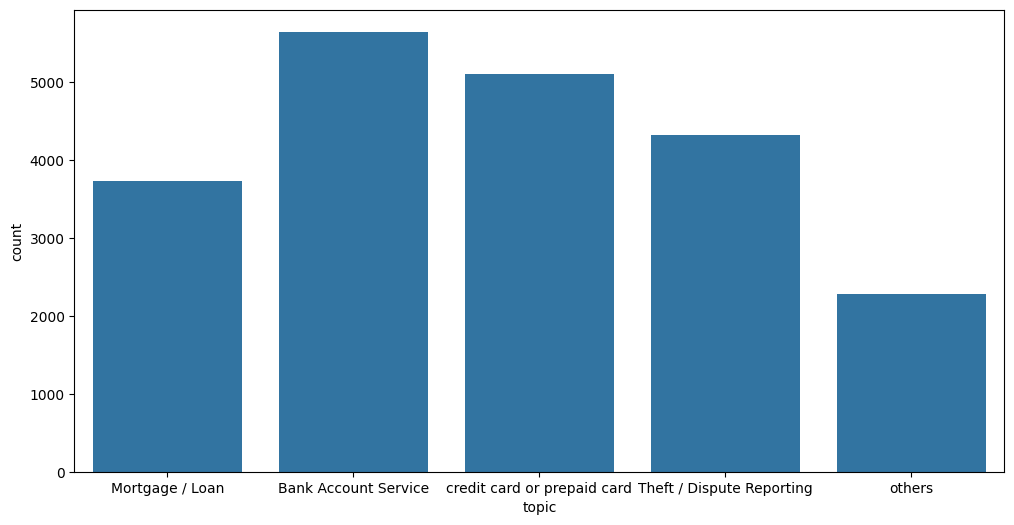

In [ ]:
# Plot graph to check class imbalance
plt.figure(figsize=(12,6))
sns.countplot(x='topic',data=df_clean)

In [ ]:
df_clean['topic'].value_counts()

,count
topic,
Bank Account Service,5646
credit card or prepaid card,5101
Theft / Dispute Reporting,4320
Mortgage / Loan,3730
others,2275


In [ ]:
df_clean['topic'].value_counts(normalize=True)*100

,proportion
topic,
Bank Account Service,26.793850
credit card or prepaid card,24.207479
Theft / Dispute Reporting,20.501139
Mortgage / Loan,17.701215
others,10.796317


# **Model building using supervised learning, Model training & evaluation**

## **Supervised model to predict any new complaints to the relevant Topics.**

- We now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

- Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [ ]:
# #Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data

training_data = df_clean[['complaint_text', 'topic']]

In [ ]:
training_data.head()

,complaint_text,topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,Mortgage / Loan
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,Bank Account Service
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,credit card or prepaid card
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,credit card or prepaid card
14,my grand son give me check for i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase times they told him i should call not him to verify the check owner he is out the country most the time date happen check number xxxx claim number is xxxx with chase,Bank Account Service


## **Reverse topic names mapping for supervised learning**


In [ ]:
## Reverse topic names mapping for supervised learning

reverse_topic_mapping = { 'Bank Account Service': 0,
                           'credit card or prepaid card': 1,
                           'others' : 2,
                           'Theft / Dispute Reporting' : 3,
                           'Mortgage / Loan' : 4 }

#Replace Topics with Topic Names

training_data['topic'] = training_data['topic'].map(reverse_topic_mapping)
training_data.head()

,complaint_text,topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,4
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,0
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,1
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,1
14,my grand son give me check for i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase times they told him i should call not him to verify the check owner he is out the country most the time date happen check number xxxx claim number is xxxx with chase,0


In [ ]:
training_data[['complaint_text','topic']][training_data.topic==2].head(30)

complaint_text  \
58                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

#### **Apply the supervised models on the training data created. In this process, you have to do the following:**
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics

## **X - Y split**

In [ ]:
x = training_data.complaint_text
y = training_data.topic

In [ ]:
#Write your code to get the Vector count

# Fit transform the X

count_vect = CountVectorizer()
x_vec = count_vect.fit_transform(x)

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer

#Write your code here to transform the word vector to tf-idf
#Fit transform word vector to TF-IDF

tfidf_transformer = TfidfTransformer()
x_tfidf = tfidf_transformer.fit_transform(x_vec)

In [ ]:
from sklearn.model_selection import train_test_split
# train test split
X_train, X_test, y_train, y_test = train_test_split(x_tfidf, y, test_size=0.25, random_state=40, stratify=y)

You have to try atleast 3 models on the train & test data from these options:
#### **We are trying the following models** -
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [ ]:
# Write your code here to build any 3 models and evaluate them using the required metrics

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_fscore_support

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


In [ ]:
# utlity function to display the model report

def display_classification_report(model,metric):

    y_train_pred_proba = model.predict_proba(X_train)
    y_test_pred_proba = model.predict_proba(X_test)
    roc_auc_score_train = round(roc_auc_score(y_train, y_train_pred_proba,average='weighted',multi_class='ovr'),2)
    roc_auc_score_test = round(roc_auc_score(y_test, y_test_pred_proba,average='weighted',multi_class='ovr'),2)
    print("ROC AUC Score Train:", roc_auc_score_train)
    print("ROC AUC Score Test:", roc_auc_score_test)
    metric.append(roc_auc_score_train)
    metric.append(roc_auc_score_test)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    precision_train,recall_train,fscore_train,support_train=precision_recall_fscore_support(y_train,y_train_pred,average='weighted')
    precision_test,recall_test,fscore_test,support_test=precision_recall_fscore_support(y_test,y_test_pred,average='weighted')

    acc_score_train = round(accuracy_score(y_train,y_train_pred),2)
    acc_score_test = round(accuracy_score(y_test,y_test_pred),2)

    metric.append(acc_score_train)
    metric.append(acc_score_test)
    metric.append(round(precision_train,2))
    metric.append(round(precision_test,2))
    metric.append(round(recall_train,2))
    metric.append(round(recall_test,2))
    metric.append(round(fscore_train,2))
    metric.append(round(fscore_test,2))

    print('Train Accuracy :',acc_score_train)
    print('Test Accuracy :',acc_score_test)

    model_report_train = classification_report(y_train,y_train_pred)
    model_report_test = classification_report(y_test,y_test_pred)

    print('Classification Report for Train:\n',model_report_train)
    print('Classification Report for Test:\n',model_report_test)


    # Plot the confusion matrix
    fig, ax = plt.subplots(figsize=(12, 8))
    # Create the confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    cmp = ConfusionMatrixDisplay(cm, display_labels=model.classes_)
    cmp.plot(ax=ax)
    plt.xticks(rotation=80)

    plt.show();

In [ ]:
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 40)

In [ ]:
# utility method to get the GridSearchCV object
def grid_search(model,folds,params,scoring):

    grid_search = GridSearchCV(model,
                                cv=folds,
                                param_grid=params,
                                scoring=scoring,
                                n_jobs=-1, verbose=1)
    return grid_search

In [ ]:
# utility function to display the best score and parameters of the GridSearchCV model
def print_best_score_params(model):
    print("Best Score: ", model.best_score_)
    print("Best Hyperparameters: ", model.best_params_)

In [ ]:
# Multinomial Naive Bayes Classification

# create MNB model object
mnb = MultinomialNB()
# fit model
mnb.fit(X_train, y_train)

# display classification report
metric1=[]
display_classification_report(mnb,metric1)

ROC AUC Score Train: 1.0
ROC AUC Score Test: 0.99
Train Accuracy : 0.95
Test Accuracy : 0.91
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.93      0.97      0.95      4234
           1       0.95      0.96      0.95      3826
           2       0.98      0.89      0.93      1706
           3       0.95      0.93      0.94      3240
           4       0.95      0.94      0.95      2798

    accuracy                           0.95     15804
   macro avg       0.95      0.94      0.94     15804
weighted avg       0.95      0.95      0.95     15804

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.88      0.93      0.91      1412
           1       0.91      0.92      0.92      1275
           2       0.95      0.82      0.88       569
           3       0.91      0.90      0.90      1080
           4       0.93      0.91      0.92       932

    accuracy             

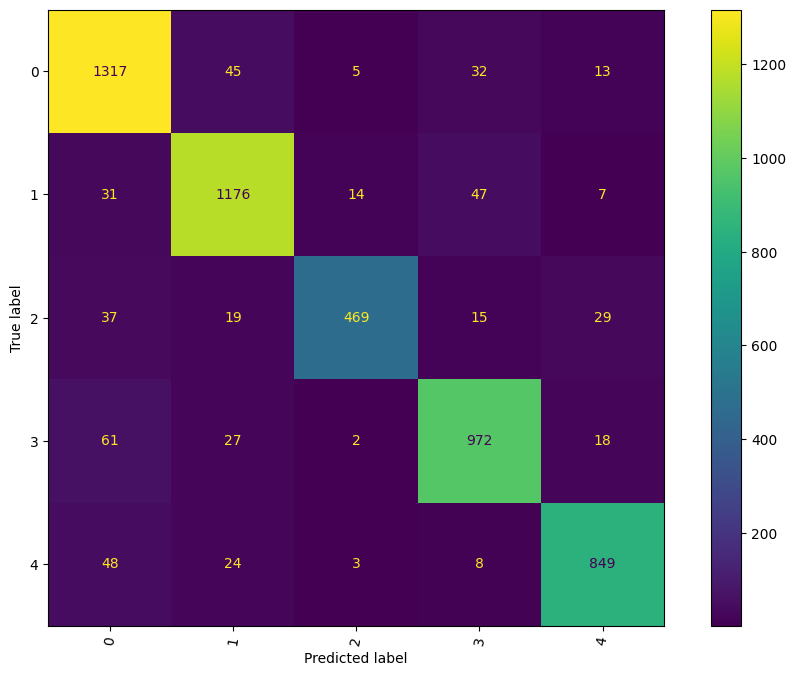

In [ ]:
# Logistic Regression Classification
log_reg = LogisticRegression(random_state=40,solver='liblinear')
# fit model
log_reg.fit(X_train,y_train)
# display classification report
metric2=[]
display_classification_report(log_reg,metric2)

ROC AUC Score Train: 1.0
ROC AUC Score Test: 0.85
Train Accuracy : 1.0
Test Accuracy : 0.76
Classification Report for Train:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4234
           1       1.00      1.00      1.00      3826
           2       1.00      1.00      1.00      1706
           3       1.00      1.00      1.00      3240
           4       1.00      1.00      1.00      2798

    accuracy                           1.00     15804
   macro avg       1.00      1.00      1.00     15804
weighted avg       1.00      1.00      1.00     15804

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.78      0.77      0.78      1412
           1       0.79      0.80      0.79      1275
           2       0.75      0.72      0.73       569
           3       0.70      0.74      0.72      1080
           4       0.80      0.77      0.78       932

    accuracy              

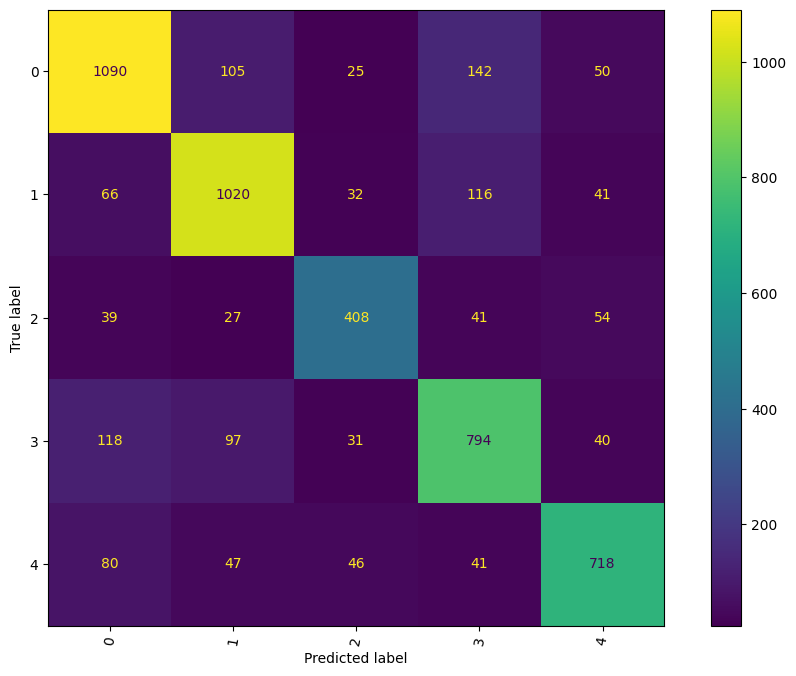

In [ ]:
# Decision Tree Classification
dtc = DecisionTreeClassifier(random_state=40)
# fit model
dtc.fit(X_train,y_train)

# Decision Tree Classification Report
metric3=[]
display_classification_report(dtc,metric3)

OOB SCORE : 0.8134649455833967
ROC AUC Score Train: 1.0
ROC AUC Score Test: 0.97
Train Accuracy : 1.0
Test Accuracy : 0.82
Classification Report for Train:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4234
           1       1.00      1.00      1.00      3826
           2       1.00      1.00      1.00      1706
           3       1.00      1.00      1.00      3240
           4       1.00      1.00      1.00      2798

    accuracy                           1.00     15804
   macro avg       1.00      1.00      1.00     15804
weighted avg       1.00      1.00      1.00     15804

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.77      0.92      0.84      1412
           1       0.81      0.87      0.84      1275
           2       0.97      0.40      0.57       569
           3       0.83      0.83      0.83      1080
           4       0.86      0.83      0.85       

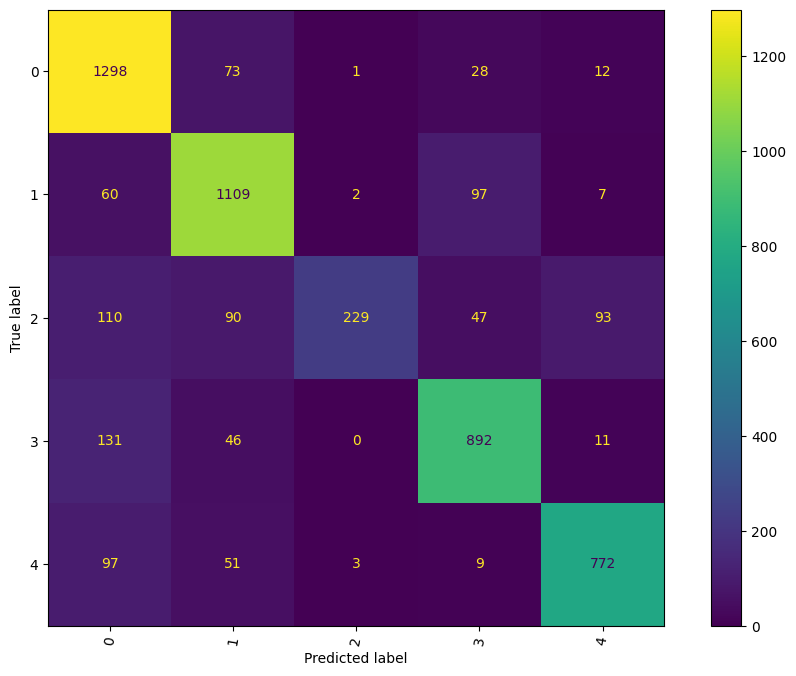

In [ ]:
# Random Forest Classification

rf = RandomForestClassifier(n_estimators = 500,random_state=40, n_jobs = -1,oob_score=True)
# fit model
rf.fit(X_train,y_train)

# oob score
print('OOB SCORE :',rf.oob_score_)

# Random Forest Classification Report
metric4=[]
display_classification_report(rf,metric4)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Score:  0.7588578161853924
Best Hyperparameters:  {'alpha': 0.01}
ROC AUC Score Train: 0.99
ROC AUC Score Test: 0.94
Train Accuracy : 0.89
Test Accuracy : 0.76
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.88      0.93      0.90      4234
           1       0.87      0.90      0.89      3826
           2       0.91      0.79      0.85      1706
           3       0.91      0.90      0.90      3240
           4       0.93      0.90      0.91      2798

    accuracy                           0.89     15804
   macro avg       0.90      0.88      0.89     15804
weighted avg       0.89      0.89      0.89     15804

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.75      0.84      0.79      1412
           1       0.76      0.74      0.75      1275
           2       0.71      0.52      0.60       569
  

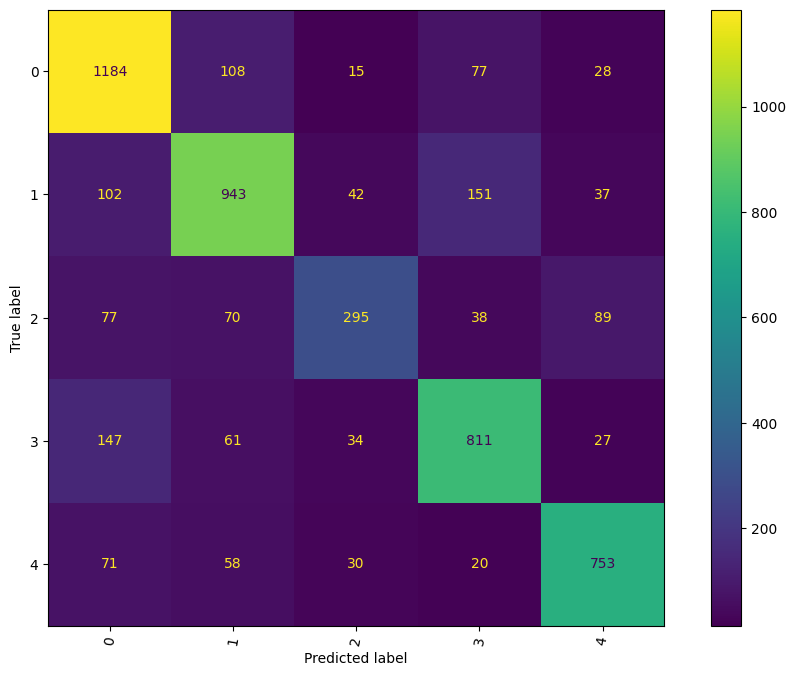

In [ ]:
# Multinomial Naive Bayes with GridSearchCV

mnb = MultinomialNB()

mnb_params = {
'alpha': (1, 0.1, 0.01, 0.001, 0.0001)
}

# create gridsearch object
grid_search_mnb = grid_search(mnb, folds, mnb_params, scoring=None)

# fit model
grid_search_mnb.fit(X_train, y_train)

# print best hyperparameters
print_best_score_params(grid_search_mnb)

# Random Forest Classification Report
metric5=[]
display_classification_report(grid_search_mnb,metric5)

In [ ]:
# Logistic Regression with GridSearchCV

# logistic regression
log_reg = LogisticRegression()

# hyperparameter for Logistic Regression
log_params = {'C': [0.01, 1, 10],
          'penalty': ['l1', 'l2'],
          'solver': ['liblinear','newton-cg','saga']
         }

# create gridsearch object
grid_search_log = grid_search(log_reg, folds, log_params, scoring=None)

# fit model
grid_search_log.fit(X_train, y_train)

# print best hyperparameters
print_best_score_params(grid_search_log)

# Random Forest Classification Report
metric6=[]
display_classification_report(grid_search_log,metric6)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


In [ ]:
# Decision Tree Classification wuth GridSearchCV

dtc = DecisionTreeClassifier(random_state=40)

dtc_params = {
    'max_depth': [5,10,20,30],
    'min_samples_leaf': [5,10,20,30]
}

# create gridsearch object
grid_search_dtc = grid_search(dtc, folds, dtc_params, scoring='roc_auc_ovr')

# fit model
grid_search_dtc.fit(X_train, y_train)

# print best hyperparameters
print_best_score_params(grid_search_dtc)

# Random Forest Classification Report
metric7=[]
display_classification_report(grid_search_dtc,metric7)

In [ ]:
# Random Forest Classifier with GridSearchCV

rfc = RandomForestClassifier(random_state=40, n_jobs = -1,oob_score=True)

# hyperparameters for Random Forest
rfc_params = {'max_depth': [10,20,30,40],
          'min_samples_leaf': [5,10,15,20,30],
          'n_estimators': [100,200,500,700]
        }

# create gridsearch object
grid_search_rfc = grid_search(rfc, folds, rfc_params, scoring='roc_auc_ovr')

# fit model
grid_search_rfc.fit(X_train, y_train)

# oob score
print('OOB SCORE :',grid_search_rfc.best_estimator_.oob_score_)

# print best hyperparameters
print_best_score_params(grid_search_rfc)

# Random Forest Classification Report
metric8=[]
display_classification_report(grid_search_rfc,metric8)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


In [ ]:
table = {'Metric': ['ROC_AUC Score(Train)','ROC_AUC Score(Test)',
                    'Accuracy(Train)','Accuracy(Test)',
                    'Precision(Train)','Precision(Test)',
                    'Recall(Train)','Recall(Test)',
                    'F1-Score(Train)','F1-Score(Test)'
                   ],
        'Multinomial Naive Bayes': metric1
        }

mnb_metric = pd.DataFrame(table ,columns = ['Metric', 'Multinomial Naive Bayes'] )
log_metric = pd.Series(metric2, name = 'Logistic Regression')
dtc_metric = pd.Series(metric3, name = 'Decision Tree Classifier')
rfc_metric = pd.Series(metric4, name = 'Random Forest Classifier')
grid_mnb_metric = pd.Series(metric5, name = 'Multinomial Naive Bayes with GridSearchCV')
grid_log_metric = pd.Series(metric6, name = 'Logistic Regression with GridSearchCV')
grid_dtc_metric = pd.Series(metric7, name = 'Decision Tree Classifier with GridSearchCV')
grid_rfc_metric = pd.Series(metric8, name = 'Random Forest Classifier with GridSearchCV')

final_metric = pd.concat([mnb_metric,log_metric,dtc_metric,rfc_metric,
                         grid_mnb_metric,grid_log_metric,grid_dtc_metric,grid_rfc_metric], axis = 1)

final_metric

In [ ]:
# raw complaint text
test_complaint= 'I tried to make a transaction at a supermarket retail store, using my chase \
debit/atm card, but the transaction was declined. I am still able to withdraw money out of an \
ATM machine using the same debit card. Please resolve this issue.'

In [ ]:
# vectorize and tf-idf tranform
test = count_vect.transform([test_complaint])
test_tfidf = tfidf_transformer.transform(test)

In [ ]:
# predict
prediction=grid_search_log.predict(test_tfidf)
prediction

Models That Support predict_proba

✅ Logistic Regression
✅ Random Forest
✅ Gradient Boosting
✅ XGBoost / LightGBM / CatBoost
✅ Naive Bayes
✅ Neural Networks (via softmax)

❌ SVM (only if probability=True)
❌ KMeans (not classification)

Method	Output
predict()	Final class
predict_proba()	Probability of each class

🔹 Common Use Cases

✔ Threshold tuning
✔ ROC–AUC calculation
✔ Risk scoring
✔ Medical / Finance models
✔ Confidence-based decisions

In [ ]:
topic_mapping[prediction[0]]

In [ ]:
# 🔹 Getting Final Class from Probability # model.predict(X_test),       np.argmax(model.predict_proba(X_test), axis=1)
# predict_proba() returns the probability of each class for a given input.           [0.1, 0.7, 0.2]